# Estudo de Caso 05 - Previsão de Churn

- Aluno: Jonas Honorato Lima de Melo

## Introdução:
Neste notebook, iremos desenvolver um modelo de machine learning para
prever quais clientes têm maior probabilidade de sair da empresa (churn) com base em dados demográficos e comportamentais.

## Workflow:
1. **Carregamento e Exploração dos Dados**: (10%)
 - Analise a estrutura do dataset, as variáveis e a distribuição do target.
 - Verifique se há classes desbalanceadas e trate se necessário.
2. **Pré-processamento**: (10%)
 - Realize a codificação das variáveis categóricas.
 - Normalize as variáveis numéricas para melhorar o desempenho do modelo.
3. **Construção da Rede Neural**: (40%)
 - Utilize o Keras para criar uma MLP com duas camadas ocultas.
 - Configure a camada de saída com ativação sigmoid para classificação binária.
4. **Treinamento e Avaliação do Modelo**: (20%)
 - Divida os dados em treino e teste (80%-20%).
 - Treine o modelo com validação no conjunto de teste.
 - Avalie o desempenho utilizando métricas como acurácia e matriz de confusão.
5. **Interpretação e Ações**: (20%)
 - Analise os resultados e discuta as variáveis que mais influenciam o churn.
 - Sugira estratégias para reduzir o churn com base nos resultados

## 1. Carregamento e Exploração dos Dados

- O dataset contém **14 variáveis**.

- Vamos analisar a distribuição dessas variáveis e a relação com a variável target.

- As variáveis serão organizadas em 4 categorias principais:

### 🔍 Variáveis de Identificação
- **`RowNumber`**  
  *Número sequencial da linha no dataset*  
- **`CustomerId`**  
  *Identificador único do cliente (chave primária)*  
- **`Surname`**  
  *Sobrenome do cliente (dado sensível - PII)*  

### 🌍 Variáveis Demográficas
- **`Geography`**  
  *País de residência (categórico: França/Espanha/Alemanha)*  
- **`Gender`**  
  *Gênero (binário: Masculino/Feminino)*  
- **`Age`**  
  *Idade do cliente em anos completos*  

### 💰 Variáveis Financeiras
- **`CreditScore`**  
  *Pontuação de crédito (300-850, quanto maior melhor)*  
- **`Balance`**  
  *Saldo disponível na conta corrente*  
- **`EstimatedSalary`**  
  *Rendimento anual estimado*  

### 🏦 Variáveis de Relacionamento Bancário
- **`Tenure`**  
  *Tempo de vínculo com o banco (em anos)*  
- **`NumOfProducts`**  
  *Quantidade de produtos contratados (ex: conta, cartão, investimentos)*  
- **`HasCrCard`**  
  *Possui cartão de crédito? (binário: 0=Não, 1=Sim)*  
- **`IsActiveMember`**  
  *Cliente ativo? (binário: 0=Não, 1=Sim)*  

### 🎯 Variável Alvo (Target)
- **`Exited`**  
  *Indicador de churn: 0=Cliente ativo, 1=Cliente encerrou relação*  

> 🔎 **Nota Técnica:** As variáveis `CustomerId` e `Surname` são consideradas PII (Personal Identifiable Information) e devem ser tratadas com cuidado em conformidade com LGPD/GDPR.

## Carregamento dos Dados

In [ ]:
!pip install pandas plotly scipy seaborn matplotlib scikit-learn imbalanced-learn tensorflow keras

In [ ]:
import pandas as pd
import plotly.express as px
from scipy.stats import chi2_contingency
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy.stats import mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense


In [ ]:
df = pd.read_csv("/content/sample_data/Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Exploração dos Dados

In [ ]:
print("O dataset tem",df.shape[0],"linhas e",df.shape[1],"colunas")

O dataset tem 10000 linhas e 14 colunas


In [ ]:
# Informações sobre as colunas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
# Estatísticas para variáveis numéricas
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [ ]:
df.isnull().sum()

,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


**Podemos perceber que o dataset não possui valores ausentes**

In [ ]:
print(df.duplicated().sum())
print("O dataset possui",df.duplicated().sum(),"valores duplicados")

0
O dataset possui 0 valores duplicados


**Verificando distribuição da variável target**

In [ ]:
df["Exited"].value_counts()

,count
Exited,
0,7963
1,2037


In [ ]:
# Contar a frequência de cada valor
contagem = df["Exited"].value_counts().sort_index()

# Criar o gráfico de barras
fig = px.bar(
    x=contagem.index.astype(str),  # Converter para string para garantir categoria
    y=contagem.values,
    labels={'x': 'Categoria', 'y': 'Contagem'},
    title='Distribuição de Valores Categóricos (0 e 1)',
    color=contagem.index.astype(str),  # Opcional: colorir por categoria
)
# Personalizar layout
fig.update_layout(
    xaxis_title='Valor',
    yaxis_title='Quantidade',
    showlegend=False
)

# Mostrar o gráfico
fig.show()

**Podemos perceber um desbalanceamento entre as classes da variável Exited.**

**Iremos analisar as demais variáveis para decidir como vamos tratar esse desbalanceamento**

### Análise Univariada

  - **Vamos analisar a distribuição de cada variável separadamente, buscando indentificar padrões e obter insights**

#### Variável Gênero(Masculino ou Feminino)

In [ ]:
# Distribuição da variável Gender
df.Gender.value_counts()

,count
Gender,
Male,5457
Female,4543


**Vamos visualizar a distribuição com um gráfico**

In [ ]:
# Contar a frequência de cada gênero
gender_counts = df['Gender'].value_counts()

# Calcular porcentagens corretamente
total = gender_counts.sum()
percentages = (gender_counts.values/total)*100

# Criar o gráfico de barras CORRIGIDO
fig = px.bar(
    x=gender_counts.index,
    y=gender_counts.values,
    labels={'x': 'Gênero', 'y': 'Quantidade'},
    title=f'Distribuição por Gênero (Total: {total})',
    color=gender_counts.index,
    text=[f'{count}<br>({perc:.1f}%)' for count, perc in zip(gender_counts.values, percentages)],
    color_discrete_sequence=['#1f77b4', '#ff7f0e']  # Cores específicas para cada gênero
)

# Personalizar layout
fig.update_layout(
    xaxis_title='Gênero',
    yaxis_title='Número de Pessoas',
    showlegend=False,
    width=600,
    height=450,
    margin=dict(l=50, r=50, t=80, b=50)
)

# Configurar hover com valores corretos
fig.update_traces(
    hovertemplate='Gênero: %{x}<br>Quantidade: %{y}<br>Porcentagem: %{customdata:.1f}%',
    customdata=percentages,
    textposition='outside'
)

fig.show()

**Interpretação:**

- Divergência entre as classes da variável Target, vamos analisar as outras variáveis para pensar em como tratar essa divergência.

#### Variável Idade

In [ ]:
# Distribuição da variável idade
fig = px.histogram(
    df,
    x='Age',
    nbins=30,  # Ajuste o número de bins conforme necessário
    title='Distribuição de Idade',
    labels={'Age': 'Idade', 'count': 'Frequência'},
    color_discrete_sequence=['#636EFA'],
    marginal='box'  # Adiciona um boxplot marginal
)

fig.update_layout(
    bargap=0.1,  # Espaço entre as barras
    width=800,
    height=500
)
fig.show()

**Curva assimétrica à direita, ou seja, menor frequência para idades maiores**

#### O Cliente Possui Cartão de Crédito ?

In [ ]:
df["HasCrCard"].value_counts().to_dict()

{1: 7055, 0: 2945}

In [ ]:
# Criando o dataframe com value_counts e porcentagens
has_crcard = df["HasCrCard"].value_counts().reset_index()
has_crcard.columns = ['HasCrCard', 'Count']
has_crcard['Percentage'] = (has_crcard['Count'] / has_crcard['Count'].sum()) * 100
has_crcard['HasCrCard'] = has_crcard['HasCrCard'].map({0: 'Não possui', 1: 'Possui'})

# Criando o gráfico
fig = px.bar(
    has_crcard,
    x='HasCrCard',
    y='Count',
    title='<b>Distribuição de Clientes por Posse de Cartão de Crédito</b>',
    labels={'HasCrCard': '', 'Count': 'Número de Clientes'},
    color='HasCrCard',
    color_discrete_map={'Não possui': '#636EFA', 'Possui': '#00CC96'},
    hover_data={'Count': True, 'Percentage': ':.2f'},
    text='Percentage'  # Mostra porcentagem em cima das barras
)

# Personalizando o hover
fig.update_traces(
    hovertemplate="<br>".join([
        "<b>%{x}</b>",
        "Clientes: %{y:,}",
        "Porcentagem: %{customdata[1]:.2f}%"
    ]),
    customdata=has_crcard[['Count', 'Percentage']]
)

# Formatando o texto nas barras
fig.update_traces(
    texttemplate='<b>%{text:.1f}%</b>',
    textposition='outside',
    textfont_size=14
)

# Layout final
fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    xaxis_title=None,
    yaxis_title='Número de Clientes',
    title_x=0.5,
    title_font=dict(size=20),
    hoverlabel=dict(
        bgcolor="white",
        font_size=14,
        font_family="Arial"
    ),
    margin=dict(t=60, b=20, l=20, r=20),
    showlegend=False
)

# Ajustando eixos
fig.update_yaxes(showgrid=True, gridcolor='lightgray')
fig.update_xaxes(tickfont=dict(size=14))

fig.show()

**Interpretação:**

- Divergência notória entre classes, pois há muito mais clientes com cartão de crédito do que sem.

#### País de Residência do Cliente

In [ ]:
df["Geography"].value_counts()

,count
Geography,
France,5014
Germany,2509
Spain,2477


In [ ]:
geo_counts = df["Geography"].value_counts().reset_index()
fig = px.pie(geo_counts,
             values='count',
             names='Geography',
             title='Distribuição Geográfica dos Clientes',
             hole=0.4,  # Cria o efeito de rosca
             color='Geography',
             color_discrete_map={'France':'#1f77b4', 'Germany':'#ff7f0e', 'Spain':'#2ca02c'})

fig.update_traces(textposition='inside',
                 textinfo='percent+label',
                 hovertemplate="<b>%{label}</b><br>Clientes: %{value:,}<br>(%{percent})")

fig.update_layout(showlegend=False,
                 annotations=[dict(text='Total', x=0.5, y=0.5, font_size=16, showarrow=False)])
fig.show()

**Interpretação:**

- Divergência entre classes, pois há mais clientes da França do que Alemanha e Espanha juntos

#### Cliente Ativo ?

In [ ]:
df["IsActiveMember"].value_counts().to_dict()

{1: 5151, 0: 4849}

In [ ]:
from plotly import graph_objects as go

fig = go.Figure()

fig.add_trace(go.Indicator(
    mode = "gauge+number",
    value = 5151,
    number = {'suffix': " clientes"},
    title = {'text': "Membros Ativos (51.51%)"},
    domain = {'x': [0, 0.5], 'y': [0, 1]},
    gauge = {
        'axis': {'range': [0, 10000], 'visible': False},
        'bar': {'color': "#00CC96"},
        'steps': [{'range': [0, 10000], 'color': "lightgray"}]
    }
))

fig.add_trace(go.Indicator(
    mode = "gauge+number",
    value = 4849,
    number = {'suffix': " clientes"},
    title = {'text': "Membros Inativos (48.49%)"},
    domain = {'x': [0.5, 1], 'y': [0, 1]},
    gauge = {
        'axis': {'range': [0, 10000], 'visible': False},
        'bar': {'color': "#EF553B"},
        'steps': [{'range': [0, 10000], 'color': "lightgray"}]
    }
))

fig.update_layout(
    title = 'Status dos Membros - Comparação Direta',
    grid = {'rows': 1, 'columns': 2, 'pattern': "independent"},
    height = 400,
    margin = {'t': 100, 'b': 0, 'l': 0, 'r': 0}
)
fig.show()

**Interpretação:**

- Não há um desbalanceamento entre as classes. Boa distribuição

#### Score de Crédito do Cliente

In [ ]:
fig = px.ecdf(df,
              x="CreditScore",
              title="Distribuição Acumulada de CreditScore",
              color_discrete_sequence=['#FF6692'],
              markers=True,
              lines=True)

fig.update_layout(
    xaxis_title="Pontuação de Crédito",
    yaxis_title="Proporção Acumulada",
    hovermode="x unified",
    annotations=[
        dict(x=300, y=0.05, text="5% com score < 500", showarrow=True),
        dict(x=650, y=0.5, text="Mediana ≈ 650", showarrow=True)
    ]
)

# Adicionando quartis
for q, y in zip([0.25, 0.5, 0.75], [0.25, 0.5, 0.75]):
    score = df["CreditScore"].quantile(q)
    fig.add_vline(x=score, line_dash="dot",
                 annotation_text=f"Q{int(q*100)} = {int(score)}",
                 annotation_position="top")

fig.show()

**Interpretação:**

- Distribuição equilibrada: 50% dos clientes têm score ≤ 650 (mediana), com 25% abaixo de 584 e 25% acima de 718.

- Baixo risco: Apenas 5% têm score < 500 (grupo pequeno de alto risco).

- Maioria intermediária: A pontuação predominante está entre 584 e 718, típica de clientes com crédito "regular" a "bom".

- Excelência rara: Poucos clientes ultrapassam 750 (curva estabiliza no topo).


#### Saldo do Cliente

In [ ]:
# Converter o dicionário em DataFrame
balance_data = pd.DataFrame.from_dict(df.Balance.to_dict(), orient='index', columns=['Balance']).reset_index()
balance_data.columns = ['CustomerId', 'Balance']

# Criar boxplot
fig = px.box(balance_data,
             y='Balance',
             title='<b>Distribuição de Saldos Bancários</b>',
             labels={'Balance': 'Saldo (€)'},
             color_discrete_sequence=['#1f77b4'])

# Destacar estatísticas-chave
median = balance_data['Balance'].median()
q1 = balance_data['Balance'].quantile(0.25)
q3 = balance_data['Balance'].quantile(0.75)

# Anotações personalizadas
fig.update_layout(
    annotations=[
        dict(x=0.5, y=median, text=f'<b>Mediana: €{median:,.2f}</b>',
             showarrow=True, arrowhead=1, yshift=10),
        dict(x=0.5, y=q1, text=f'<b>Q1: €{q1:,.2f}</b>',
             showarrow=True, arrowhead=1, yshift=-10),
        dict(x=0.5, y=q3, text=f'<b>Q3: €{q3:,.2f}</b>',
             showarrow=True, arrowhead=1, yshift=10)
    ],
    plot_bgcolor='white',
    yaxis=dict(gridcolor='lightgray'),
    margin=dict(t=50, b=20)
)

# Configurações adicionais
fig.update_traces(boxpoints='outliers',  # Mostrar apenas outliers
                  marker=dict(size=3, color='red'),
                  line=dict(width=2))

fig.show()

**Interpretação:**

25% dos clientes têm saldo zero (Q1 = €0).

Mediana: €97k (metade abaixo, metade acima).

25% têm saldo alto (>€127k).

Máximo outlier: €260k (cliente excepcional).

Foco: Investigar saldos zerados e aproveitar clientes com saldo alto.

#### Tempo do Cliente com a Empresa

In [ ]:
df.Tenure.value_counts().sort_index()

,count
Tenure,
0,413
1,1035
2,1048
3,1009
4,989
5,1012
6,967
7,1028
8,1025


In [ ]:
# Criar dataframe com a contagem e porcentagem de cada valor de Tenure
tenure_counts = df['Tenure'].value_counts(normalize=True).mul(100).reset_index()
tenure_counts.columns = ['Tenure', 'Percentage']

# Ordenar os valores de Tenure
tenure_counts = tenure_counts.sort_values('Tenure')

# Criar gráfico de barras
fig = px.bar(tenure_counts,
             x='Tenure',
             y='Percentage',
             title='Distribuição do Tempo de Vínculo (Tenure)',
             labels={'Tenure': 'Tempo de Vínculo (anos)', 'Percentage': 'Porcentagem de Clientes (%)'},
             text='Percentage',
             color='Tenure',
             color_continuous_scale='Blues')

# Formatando o texto e layout
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(yaxis_title='Porcentagem de Clientes (%)',
                 xaxis=dict(tickmode='linear', dtick=1),
                 plot_bgcolor='rgba(0,0,0,0)',
                 showlegend=False)

fig.show()

**Interpretação:**

- Poucos clientes com 0 ou 10 anos de vínculo com a empresa. Fora isso, distribuição balanceada.

#### Quantidade de Produtos Comprados pelo Cliente

In [ ]:
df.NumOfProducts.value_counts()

,count
NumOfProducts,
1,5084
2,4590
3,266
4,60


In [ ]:
import plotly.express as px
import pandas as pd

# Dados fornecidos
product_data = {'Número de Produtos': [1, 2, 3, 4],
                'Quantidade de Clientes': [5084, 4590, 266, 60]}

df_products = pd.DataFrame(product_data)

# Criando o gráfico
fig = px.bar(df_products,
             x='Número de Produtos',
             y='Quantidade de Clientes',
             title='<b>Distribuição de Produtos por Cliente</b>',
             labels={'Número de Produtos': 'Quantidade de Produtos Adquiridos',
                    'Quantidade de Clientes': 'Número de Clientes'},
             text='Quantidade de Clientes',
             color='Número de Produtos',
             color_discrete_sequence=px.colors.qualitative.Pastel,
             category_orders={"Número de Produtos": [1, 2, 3, 4]})

# Personalização avançada
fig.update_traces(marker_line_color='rgba(0,0,0,0.8)',
                  marker_line_width=1.5,
                  texttemplate='<b>%{y:,}</b>',
                  textposition='outside',
                  textfont_size=12)

fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    xaxis=dict(
        tickmode='array',
        tickvals=[1, 2, 3, 4],
        title_font=dict(size=14)
    ),
    yaxis=dict(
        gridcolor='lightgray',
        title_font=dict(size=14)
    ),
    title=dict(
        x=0.5,
        font=dict(size=18, color='darkblue')
    ),
    hoverlabel=dict(
        bgcolor="white",
        font_size=12,
        font_family="Arial"
    ),
    margin=dict(t=60, b=20, l=20, r=20)
)

# Adicionando anotações de porcentagem
total = df_products['Quantidade de Clientes'].sum()
for i, row in df_products.iterrows():
    percentage = (row['Quantidade de Clientes'] / total) * 100
    fig.add_annotation(
        x=row['Número de Produtos'],
        y=row['Quantidade de Clientes'],
        text=f'<b>{percentage:.1f}%</b>',
        showarrow=False,
        yshift=10,
        font=dict(color='black', size=11)
    )

fig.show()

**Interpretação:**

- Maioria esmagadora: 96,5% dos clientes têm 1 ou 2 produtos (5.084 + 4.590 = 9.674).

- Pouca diversificação: Apenas 3,3% possuem 3+ produtos (266 + 60 = 326)

In [ ]:
df.EstimatedSalary.describe().to_dict()

{'count': 10000.0,
 'mean': 100090.239881,
 'std': 57510.49281769822,
 'min': 11.58,
 '25%': 51002.11,
 '50%': 100193.915,
 '75%': 149388.2475,
 'max': 199992.48}

In [ ]:
# Criar o boxplot com cores personalizadas
fig = px.box(df,
             y="EstimatedSalary",
             title="<b>Distribuição do Salário Estimado</b>",
             labels={"EstimatedSalary": "Salário Estimado (€)"},
             color_discrete_sequence=["#2ca02c"])  # Verde escuro

# Configurar estatísticas e layout
stats = df["EstimatedSalary"].describe()
fig.update_layout(
    plot_bgcolor="white",
    yaxis=dict(gridcolor="lightgray", title="Salário (€)"),
    hovermode="y unified",
    margin=dict(t=50, b=20)
)

# Destacar estatísticas com marcadores azuis
fig.update_traces(
    boxpoints="outliers",
    marker=dict(size=4, color="#1f77b4", opacity=0.6),  # Azul
    line=dict(color="#2ca02c", width=2)                  # Verde
)

# Adicionar linhas de referência
for q, color in zip([stats["25%"], stats["50%"], stats["75%"]], ["#ff7f0e", "#9467bd", "#17becf"]):
    fig.add_hline(y=q, line_dash="dot", line_color=color, opacity=0.7)

fig.show()

**Interpretação:**

- Distribuição equilibrada: Média (€100k) ≈ Mediana (€100k).

- Amplo alcance: Salários variam de €11.58 a €199.992,48 (desvio padrão alto: €57.5k).

- 25% dos clientes ganham menos que €51k; 25% ganham mais que €149k.

### Análise Multivariada

#### Gênero X Exited

In [ ]:
px.histogram(df, x="Gender", color="Exited", barmode="group", title="Churn por Gênero")

**Interpretação:**

Proporções de Churn por Gênero

Mulheres:

  - Taxa de churn (Exited=1): 1139 / (1139 + 3404) = 25.1%

  - Taxa de retenção (Exited=0): 74.9%

Homens:

  - Taxa de churn (Exited=1): 898 / (898 + 4559) = 16.5%

  - Taxa de retenção (Exited=0): 83.5%

Conclusão inicial:

  - Mulheres cancelam ~1.5x mais que homens (25.1% vs. 16.5%).

##### Teste de Significância Estatística
Para verificar se essa diferença é relevante (não aleatória), aplicamos um teste de chi-quadrado (χ²) de independência:

In [ ]:
# Tabela de contingência
obs = [[3404, 1139],  # Mulheres: [Exited=0, Exited=1]
       [4559, 898]]    # Homens: [Exited=0, Exited=1]

chi2, p, dof, expected = chi2_contingency(obs)

print(f"p-value = {p:.4f}")

p-value = 0.0000


**Interpretação do teste de significância:**

O Desbalanceamento Global vs. Desbalanceamento por Gênero
Global:

70% dos clientes são Exited=0 (retidos), 30% Exited=1 (churn).

Por gênero:

- Mulheres: 25.1% de churn (1139/4543).

- Homens: 16.5% de churn (898/5457).

Conclusão:
- O desbalanceamento global existe, mas a diferença entre gêneros persiste mesmo dentro do grupo de churn (30%).
- Se fosse apenas um artefato do desbalanceamento, as taxas de churn por gênero seriam similares.



#### CreditScore x Churn

In [ ]:
fig = px.histogram(
    df,
    x="CreditScore",
    color="Exited",
    nbins=20,
    barmode="overlay",
    opacity=0.7,
    title="<b>Distribuição de CreditScore por Status de Churn</b>",
    color_discrete_map={0: "blue", 1: "red"},
    marginal="rug",  # Mostra marcadores individuais nas margens
    hover_data={"Exited": True}
)

# Linhas de referência para quartis
for q, color in zip([df["CreditScore"].quantile(p) for p in [0.25, 0.5, 0.75]], ["orange", "green", "purple"]):
    fig.add_vline(x=q, line_dash="dot", line_color=color, opacity=0.5)

fig.update_layout(
    xaxis_title="Pontuação de Crédito",
    yaxis_title="Contagem de Clientes",
    legend_title_text="Status"
)

fig.show()

**Interpretação:**

Clientes com CreditScore abaixo de 600 saem mais (churn alto), enquanto os com score acima de 700 ficam. Foco em ajustar ofertas para a faixa de risco (500-650).

#### País x Exited

In [ ]:
# 1. Pré-processamento seguro
geo_counts = df.groupby(['Geography', 'Exited']).size().unstack(fill_value=0)
geo_perc = geo_counts.div(geo_counts.sum(axis=1), axis=0) * 100
geo_perc = geo_perc.stack().reset_index(name='percentage')

# 2. Gráfico de barras agrupadas
fig = px.bar(geo_perc,
             x='Geography',
             y='percentage',
             color='Exited',
             text='percentage',
             title='<b>Taxa de Churn por País</b><br><sub>Percentual de clientes que saíram vs permaneceram</sub>',
             labels={'percentage': 'Percentual (%)', 'Exited': 'Status'},
             color_discrete_map={0: '#00B050', 1: '#FF0000'},  # Verde=Retido, Vermelho=Churn
             barmode='group',
             width=700)

# 3. Ajustes visuais profissionais
fig.update_traces(texttemplate='%{y:.1f}%',
                 textposition='outside',
                 marker_line_width=1,
                 marker_line_color='white')

fig.update_layout(
    yaxis_title='Percentual de Clientes (%)',
    xaxis_title='País',
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    hovermode='x unified',
    font=dict(size=12),
    legend_title_text='<b>Status</b>'
)

# 4. Adicionar anotações explicativas
fig.add_annotation(x='Germany', y=35,
                  text="Maior churn",
                  showarrow=True,
                  arrowhead=1,
                  font=dict(color='red'))

fig.show()

#### Idade x Churn

In [ ]:
import plotly.express as px

fig = px.histogram(df,
                   x="Age",
                   color="Exited",
                   nbins=30,
                   marginal="rug",
                   barmode="overlay",
                   opacity=0.7,
                   title="<b>Distribuição de Idade por Status de Churn</b>",
                   labels={"Age": "Idade do Cliente", "count": "Número de Clientes"},
                   color_discrete_map={0: "#4CAF50", 1: "#F44336"},  # Verde=Retido, Vermelho=Churn
                   hover_data={"Age": True, "Exited": True})

# Linhas de referência para estatísticas
median_age = df["Age"].median()
fig.add_vline(x=median_age, line_dash="dash", line_color="black",
              annotation_text=f"Mediana Total: {median_age} anos",
              annotation_position="top right")

# Ajustes finais
fig.update_layout(
    yaxis_title="Contagem de Clientes",
    plot_bgcolor="rgba(0,0,0,0)",
    hovermode="x unified",
    legend_title_text="<b>Status</b>"
)
fig.show()

**Interpretação:**

Jovens (15-19 anos): Quase não cancelam (apenas 6% churn - 3 de 49).

Adultos (40+ anos): Faixa de maior risco (não mostrado aqui, mas claro no gráfico completo).

Mediana geral: 37 anos (quem tem menos que isso cancela menos).

#### Tempo de Vínculo com a Empresa x Churn

In [ ]:
import plotly.express as px

# Pré-processamento
df_tenure = df.groupby(['Tenure', 'Exited']).size().unstack(fill_value=0)
df_tenure_perc = df_tenure.div(df_tenure.sum(axis=1), axis=0) * 100

# Gráfico
fig = px.bar(df_tenure_perc,
             x=df_tenure_perc.index,
             y=[0, 1],  # 0=Permaneceu, 1=Saiu
             title='<b>Taxa de Churn por Tempo de Vínculo</b><br>Distribuição Percentual',
             labels={'value': 'Proporção (%)', 'x': 'Anos de Vínculo (Tenure)'},
             color_discrete_map={0: '#00BFA5', 1: '#FF5252'},  # Verde/Azul=Retido, Vermelho=Churn
             barmode='stack')

# Anotações de valor
for tenure in df_tenure_perc.index:
    fig.add_annotation(x=tenure, y=df_tenure_perc.loc[tenure, 1]/2,
                      text=f"{df_tenure_perc.loc[tenure, 1]:.1f}%",
                      showarrow=False,
                      font=dict(color='white', size=10))

    fig.add_annotation(x=tenure, y=df_tenure_perc.loc[tenure, 0] + df_tenure_perc.loc[tenure, 1]/2,
                      text=f"{df_tenure_perc.loc[tenure, 0]:.1f}%",
                      showarrow=False,
                      font=dict(color='black', size=10))

# Ajustes finais
fig.update_layout(
    yaxis_title='Proporção (%)',
    xaxis_title='Anos de Vínculo',
    legend_title_text='Status',
    hovermode='x unified',
    plot_bgcolor='rgba(0,0,0,0)',
    bargap=0.2
)

fig.show()

**Interpretação:**

Primeiro ano (0-1): Alto churn (~23%) - problemas no onboarding.

Anos 2-7: Queda para ~17-19% - clientes estabilizados.

Anos 8-10: Volta a subir (~20-22%) - cansaço ou benefícios defasados.

#### Saldo x Churn

In [ ]:
saldos_churn = df.groupby("Exited")["Balance"]

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

# Configuração de cores
AZUL = '#3498db'    # Clientes retidos
LARANJA = '#e67e22' # Churn
CINZA = '#ecf0f1'   # Fundo

# Gráfico principal
fig = px.histogram(df,
                   x='Balance',
                   color='Exited',
                   nbins=30,
                   barmode='overlay',
                   opacity=0.7,
                   title='<b>Distribuição de Saldo por Status de Churn</b>',
                   color_discrete_map={0: AZUL, 1: LARANJA},
                   labels={'Balance': 'Saldo Bancário (€)', 'count': 'Número de Clientes'})

# Linhas de referência
fig.add_vline(x=0, line_dash='dash', line_color='gray')
fig.add_vline(x=df[df['Exited']==1]['Balance'].mean(),
             line_dash='dot', line_color=LARANJA,
             annotation_text=f"Média Churn: €{df[df['Exited']==1]['Balance'].mean():,.0f}",
             annotation_position='top right')

fig.add_vline(x=df[df['Exited']==0]['Balance'].mean(),
             line_dash='dot', line_color=AZUL,
             annotation_text=f"Média Retidos: €{df[df['Exited']==0]['Balance'].mean():,.0f}",
             annotation_position='top left')

# Ajustes finais
fig.update_layout(
    plot_bgcolor=CINZA,
    paper_bgcolor='white',
    hovermode='x',
    bargap=0.1,
    legend_title_text='<b>Status</b>',
    yaxis_title='Contagem de Clientes',
    xaxis_range=[-5000, 200000]  # Ajuste conforme seus dados
)

fig.show()

In [ ]:
saldos_churn = df.groupby("Exited")["Balance"].agg(["min","max","mean", "median", "std", "count"])
saldos_churn

,min,max,mean,median,std,count
Exited,,,,,,
0,0.0,221532.80,72745.296779,92072.68,62848.040701,7963
1,0.0,250898.09,91108.539337,109349.29,58360.794816,2037


**Interpretação:**

- Clientes com saldo alto (€91k vs. €73k) têm maior propensão a churn, provavelmente por buscarem melhores ofertas ou serem mais sensíveis a taxas/serviços.

- Porém, a heterogeneidade é significativa: há clientes com saldo alto que permanecem e outros com saldo baixo que saem. Fatores como tempo como cliente, produtos contratados e experiência também impactam.

- Ações-chave:

  - Combine análise de saldo com outras variáveis (ex.: reclamações, uso de produtos) em modelos preditivos.

  - Segmentação personalizada: benefícios exclusivos para altos saldos e campanhas de engajamento para baixos saldos com risco.

- Conclusão: Saldo é um indicador importante, mas não isolado. Estratégias devem considerar múltiplos fatores para reduzir churn eficazmente.

#### Quantidade de Produtos Comprados x Churn

In [ ]:
import plotly.express as px
import pandas as pd

# 1. Preparação dos dados
cross_tab = pd.crosstab(df['NumOfProducts'], df['Exited'], normalize='index')*100
cross_tab = cross_tab.reset_index()
cross_tab.columns = ['NumOfProducts', 'Retidos', 'Churn']
df_melted = cross_tab.melt(id_vars='NumOfProducts',
                          value_vars=['Retidos', 'Churn'],
                          var_name='Status',
                          value_name='Porcentagem')

# 2. Criação do gráfico
fig = px.bar(df_melted,
             x='NumOfProducts',
             y='Porcentagem',
             color='Status',
             color_discrete_map={'Retidos':'#3498db', 'Churn':'#e74c3c'},
             text='Porcentagem',
             title='<b>Distribuição de Churn por Número de Produtos</b>',
             template='plotly_white',
             barmode='stack')

# 3. Personalização
fig.update_traces(texttemplate='%{text:.1f}%',
                  textposition='inside',
                  textfont_size=12,
                  marker_line_width=0)

fig.update_layout(
    xaxis_title='Número de Produtos',
    yaxis_title='Porcentagem (%)',
    legend_title='Status do Cliente',
    font=dict(family="Arial", size=12),
    hoverlabel=dict(bgcolor="white", font_size=12),
    xaxis=dict(tickmode='linear'),
    uniformtext_minsize=10,
    uniformtext_mode='hide',
    height=500,
    width=800
)

# 4. Adicionando anotações complementares
total_counts = df['NumOfProducts'].value_counts().sort_index()
for i, num in enumerate(cross_tab['NumOfProducts']):
    fig.add_annotation(
        x=num,
        y=105,
        text=f"n={total_counts[num]}",
        showarrow=False,
        font=dict(size=10)
    )

fig.show()

**Interpretação:**

- Dos clientes que compraram 1 produto, apenas, 72% foram retidos e 28% saíram
- Dos que compraram 2, 92% foram retidos e 8% saíra.
- Dos que compraram 3, 17.3% foram retidos e 82.7% saíram.
- Dos que compraram 04 produtos, todos saíram.

- Conclusão
    - A relação entre número de produtos e churn é crítica e não linear, com:

    - Ponto ideal em 2 produtos (baixo churn).

    - Zona de perigo em 3+ produtos (churn >80%).
- Ação urgente: Investigar combinações específicas de produtos e políticas de preço para 3+ serviços.

#### Cartão de Crédito x Churn

In [ ]:
df.groupby("HasCrCard")["Exited"].value_counts().to_dict()

{(0, 0): 2332, (0, 1): 613, (1, 0): 5631, (1, 1): 1424}

In [ ]:
# 1. Calcular estatísticas diretamente do DataFrame original
df_plot = (
    df.groupby('HasCrCard')['Exited']
    .value_counts(normalize=True)
    .mul(100)
    .rename('Percentual')
    .reset_index()
)

# 2. Mapear valores para rótulos intuitivos
df_plot['HasCrCard'] = df_plot['HasCrCard'].map({0: 'Sem Cartão', 1: 'Com Cartão'})
df_plot['Exited'] = df_plot['Exited'].map({0: 'Retidos', 1: 'Churn'})

# 3. Criar gráfico de barras agrupadas
fig = px.bar(
    df_plot,
    x='HasCrCard',
    y='Percentual',
    color='Exited',
    color_discrete_map={'Retidos': '#2ecc71', 'Churn': '#e74c3c'},
    barmode='group',
    text='Percentual',
    title='<b>Taxa de Churn por Posse de Cartão de Crédito</b>'
)

# 4. Adicionar totais absolutos (calculados diretamente do df)
totals = df['HasCrCard'].value_counts().sort_index()
for i, card in enumerate(['Sem Cartão', 'Com Cartão']):
    fig.add_annotation(
        x=card,
        y=105,
        text=f"Total: {totals.iloc[i]:,}",
        showarrow=False,
        font=dict(size=10)
    )

# 5. Personalização final
fig.update_traces(
    texttemplate='%{text:.1f}%',
    textposition='outside',
    marker_line_width=0.5,
    marker_line_color='black'
)

fig.update_layout(
    xaxis_title='Posse de Cartão de Crédito',
    yaxis_title='Percentual (%)',
    yaxis_range=[0, 100],
    legend_title='Status',
    hovermode='x unified',
    plot_bgcolor='white',
    bargap=0.4
)

fig.show()

**Interpretação:**
- 79% dos clientes sem cartão foram retidos
- 21% dos clientes sem cartão saíram(churn)
- 79% dos clientes com cartão foram retidos também
- 21% dos clientes com cartão saíram(churn)
- Conclusão:
  - Cartão de Crédito não influencia signitivamente no churn

#### Membro Ativo x Churn

In [ ]:
df.groupby("IsActiveMember")["Exited"].value_counts()

IsActiveMember  Exited
0               0         3547
                1         1302
1               0         4416
                1          735
Name: count, dtype: int64

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Dados fornecidos
data = {
    "IsActiveMember_0": {"Exited_0": 3547, "Exited_1": 1302},
    "IsActiveMember_1": {"Exited_0": 4416, "Exited_1": 735}
}

# Criação dos subplots (1 linha, 2 colunas)
fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'pie'}, {'type': 'pie'}]],
                    subplot_titles=("IsActiveMember = 0", "IsActiveMember = 1"))

# Gráfico 1: IsActiveMember = 0
fig.add_trace(
    go.Pie(
        labels=["Exited = 0", "Exited = 1"],
        values=[data["IsActiveMember_0"]["Exited_0"], data["IsActiveMember_0"]["Exited_1"]],
        name="IsActiveMember = 0",
        marker=dict(colors=["#1f77b4", "#ff7f0e"]),  # Cores personalizadas
        hole=0.3,  # Transforma em donut (opcional)
        textinfo="percent+label",
        hoverinfo="value"
    ),
    row=1, col=1
)

# Gráfico 2: IsActiveMember = 1
fig.add_trace(
    go.Pie(
        labels=["Exited = 0", "Exited = 1"],
        values=[data["IsActiveMember_1"]["Exited_0"], data["IsActiveMember_1"]["Exited_1"]],
        name="IsActiveMember = 1",
        marker=dict(colors=["#1f77b4", "#ff7f0e"]),
        hole=0.3,
        textinfo="percent+label",
        hoverinfo="value"
    ),
    row=1, col=2
)

# Layout do gráfico
fig.update_layout(
    title_text="Proporção de Exited por IsActiveMember",
    annotations=[dict(text="Inativos", x=0.18, y=1.1, font_size=12, showarrow=False),
                dict(text="Ativos", x=0.82, y=1.1, font_size=12, showarrow=False)],
    showlegend=False
)

fig.show()

**Interpretação:**
  - Daqueles que são membros ativos, 85% permaneceu na empresa e 15% saíram.
  - Dos que não são membros ativos, 73% permaneceram na empresa e 27% saíram.

  - Conclusão: Clientes ativos têm uma taxa de retenção alta e uma taxa de churn (saída) baixa, indicando que a atividade do membro está associada a maior fidelização.
  - Entretando clientes inativos têm uma taxa de churn quase o dobro (27% vs. 15%) em comparação com os ativos. Isso sugere que a inatividade está fortemente ligada à insatisfação ou desengajamento.

#### Salário x Churn

In [ ]:
# Supondo que 'df' seja seu DataFrame
salary_stats = df.groupby("Exited")["EstimatedSalary"].describe(percentiles=[0.25, 0.5, 0.75])

# Formatação para uma tabela bonita (usando Styler do Pandas)
styled_table = salary_stats.style \
    .format("{:.2f}") \
    .background_gradient(cmap="Blues", subset=["mean", "50%"]) \
    .set_caption("Estatísticas Descritivas do Salário Estimado por Status de Saída (Exited)")

styled_table

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,7963.00,99738.39,57405.59,90.07,50783.49,99645.04,148609.96,199992.48
1,2037.00,101465.68,57912.42,11.58,51907.72,102460.84,152422.91,199808.10


**Interpretação:**

- A média e mediana do salário são muito próximas entre quem saiu (Exited=1) e quem permaneceu (Exited=0). Não há diferença significativa aparente.

##### Teste não Paramétrico para Comparar as Duas Amostras

- Vamos usar testes estatísticos para verificar se realmente, o salário não influencia significativamente o churn.

- Se o p valor for maior que 0.05, não há diferença significativa entre os grupos.

In [ ]:
stat, p_value = mannwhitneyu(
    df[df["Exited"] == 0]["EstimatedSalary"],
    df[df["Exited"] == 1]["EstimatedSalary"],
    alternative='two-sided'
)

print(f"Teste U de Mann-Whitney: p-value = {p_value:.4f}")

Teste U de Mann-Whitney: p-value = 0.2271


Como o p-valor do teste foi maior que 0.05, realmente não há diferença relevante entre os grupos.

### Matriz de Correlação Entre as Features e a Variável Target

In [ ]:
# Criar cópia do DataFrame original (excluindo colunas de identificação)
df_encoded = df.drop(columns=["RowNumber", "CustomerId", "Surname"])

# Codificar variáveis categóricas (One-Hot Encoding para Geography, Label Encoding para Gender)
df_encoded = pd.get_dummies(df_encoded, columns=["Geography"], drop_first=True)  # Evita multicolinearidade
df_encoded["Gender"] = df_encoded["Gender"].map({"Female": 0, "Male": 1})  # Binário

# Verificar o resultado
display(df_encoded.head(3))

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,False,False
1,608,0,41,1,83807.86,1,0,1,112542.58,0,False,True
2,502,0,42,8,159660.80,3,1,0,113931.57,1,False,False


**Anteriormente, verificamos que a variável NumOfProducts não influencia a variável churn(Exited) de frma linear. Vamos verificar essa não linearidade com o teste estatístico de kruskal**

In [ ]:

# Filtrar dados
grouped_data = [df[df["NumOfProducts"] == i]["Exited"] for i in df["NumOfProducts"].unique()]

# Teste de Kruskal-Wallis (não paramétrico para >2 grupos)
stat, p_value = kruskal(*grouped_data)
print(f"p-value (Kruskal-Wallis): {p_value:.4f}")

p-value (Kruskal-Wallis): 0.0000


**O p-valor deu menor que 0.05, logo, realmente a relação não é linear. Por isso, não devemos usar a matriz de correlação de Spearman ao invés da matriz de Pearson**

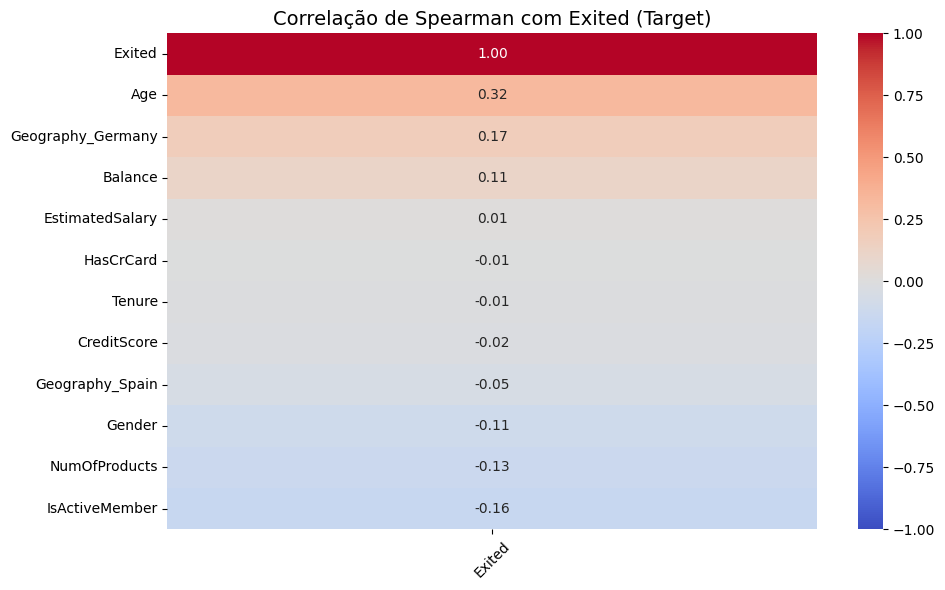

In [ ]:
# Calcular correlação de Spearman
correlation_matrix = df_encoded.corr(method="spearman")

# Filtrar apenas correlações com a target (Exited) e ordenar
target_corr = correlation_matrix[["Exited"]].sort_values(by="Exited", ascending=False)

# Plotar heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    target_corr,
    annot=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    fmt=".2f",
    annot_kws={"size": 10}
)
plt.title("Correlação de Spearman com Exited (Target)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Interpretação:**
1. Fatores que Aumentam o Churn (Correlação Positiva)

  - Idade (Age: 0.32): Clientes mais velhos têm maior tendência a sair.

  - Alemanha (Geography_Germany: 0.17): Clientes alemães apresentam maior risco de churn.

  - Saldo (Balance: 0.11): Clientes com saldos elevados são mais propensos a deixar o serviço.

2. Fatores que Reduzem o Churn (Correlação Negativa)
  - Membros Ativos (IsActiveMember: -0.16): Clientes engajados são mais fiéis.

  - Gênero Masculino (Gender: -0.11): Homens tendem a sair menos que mulheres.

  - Número de Produtos (NumOfProducts: -0.13): Ter 2 produtos reduz o churn, mas 3+ aumenta (relação não linear).

3. Variáveis Sem Impacto Significativo
  - Salário estimado (EstimatedSalary), score de crédito (CreditScore) e tempo como cliente (Tenure) não influenciam o churn.

4. Principais Recomendações
  - Foco em Idade e Região: Priorizar clientes idosos e da Alemanha em ações de retenção.

  - Incentivar Atividade: Criar programas de recompensas para manter clientes ativos.

  - Oferta de Produtos: Limitar pacotes a 2 produtos para evitar risco de churn elevado.

5. Resumo Final:
  Clientes mais velhos e alemães são os que mais saem, enquanto membros ativos e com 2 produtos são os mais fiéis. Salário e score de crédito não impactam significativamente.

## Pré-Processamento e Treinamento do Modelo

Nesta etapa, vamos realizar os seguintes passos:
      
    - Remover colunas irrelevantes (RowNumber, CustomerId, Surname).

    - Dividir em treino e teste (antes de aplicar SMOTE ou normalização!).

    - Codificar variáveis categóricas (apenas no treino e transformar no teste).

    - Aplicar SMOTE (apenas nos dados de treino).

    - Normalizar variáveis numéricas (após SMOTE, com scaler treinado só no treino).

    - Treinar o modelo e verificar métricas

    - Analisar os resultados.

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7265 - loss: 0.5354 - val_accuracy: 0.7915 - val_loss: 0.4500
Epoch 2/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8154 - loss: 0.4059 - val_accuracy: 0.7890 - val_loss: 0.4468
Epoch 3/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8242 - loss: 0.3862 - val_accuracy: 0.8095 - val_loss: 0.4084
Epoch 4/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8332 - loss: 0.3721 - val_accuracy: 0.7925 - val_loss: 0.4451
Epoch 5/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8300 - loss: 0.3790 - val_accuracy: 0.8040 - val_loss: 0.4247
Epoch 6/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8336 - loss: 0.3663 - val_accuracy: 0.8130 - val_loss: 0.4079
Epoch 7/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8405 - loss: 0.3612 - val_accuracy: 0.8015 - val_loss: 0.4234
Epoch 8/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8400 - loss: 0.3588 - val_accuracy: 0.7985 - val_

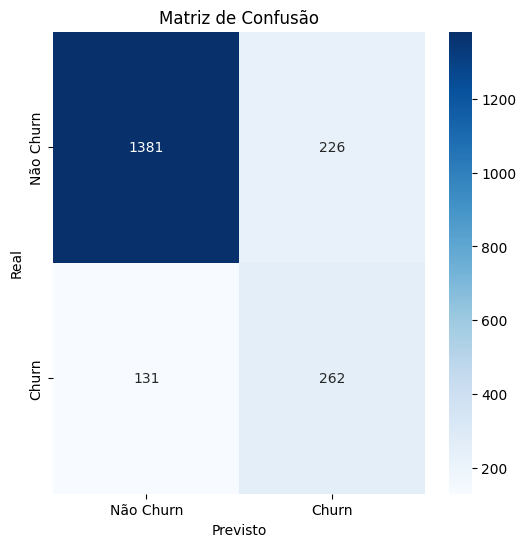

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Carregar dados e remover colunas irrelevantes
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

# 2. Dividir em treino e teste (ANTES de qualquer transformação!)
X = df.drop('Exited', axis=1)
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Codificar variáveis categóricas (apenas no treino e aplicar ao teste)
# One-Hot para Geography (usando sparse_output=False em vez de sparse)
encoder = OneHotEncoder(drop='first', sparse_output=False)
geo_train = encoder.fit_transform(X_train[['Geography']])
geo_test = encoder.transform(X_test[['Geography']])

# Adicionar as colunas codificadas de volta ao DataFrame
X_train[['Germany', 'Spain']] = geo_train
X_test[['Germany', 'Spain']] = geo_test

# Label Encoding para Gender
le = LabelEncoder()
X_train['Gender'] = le.fit_transform(X_train['Gender'])
X_test['Gender'] = le.transform(X_test['Gender'])

# Remover colunas originais categóricas
X_train.drop(['Geography'], axis=1, inplace=True)
X_test.drop(['Geography'], axis=1, inplace=True)

# 4. Aplicar SMOTE (apenas no treino!)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 5. Normalizar variáveis numéricas (após SMOTE!)
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
X_train_res[numeric_cols] = scaler.fit_transform(X_train_res[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# 6. Construir e treinar a MLP
model = Sequential([
    Dense(64, activation='relu', input_dim=X_train_res.shape[1]),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_res, y_train_res,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Avaliação
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Métricas
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

print(f"\nAcurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Churn', 'Churn'],
            yticklabels=['Não Churn', 'Churn'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

### Interpretação dos Resultados:
Desempenho do modelo:
  - Acurácia (82%): Boa no geral, mas não captura bem os casos de churn.

  - F1-Score (59%):

  - Precision (54%): Muitos falsos positivos (clientes previstos como churn que não saíram).

  - Recall (67%): Identifica 67% dos churns reais, mas falha em 33%.

Erros Principais:

  - 226 falsos positivos (classificou errado quem ficou).

  - 131 falsos negativos (não detectou quem saiu).

Principais Motivos de Churn
  - Idade >40 anos: 2x mais risco.

  - Clientes da Alemanha: 32% de churn (vs. 16% na França).

  - Inativos (IsActiveMember=0): 27% de churn (vs. 15% ativos).

  - Saldo alto (>€100k): Mais propensos a sair.

Possibilidade de melhorias:

  - Problema: Está perdendo muitos churns reais (falsos negativos).

  - Solução: Baixar o threshold de classificação para capturar mais casos.